# Parameter estimation tutorial

In this tutorial, we will put a couple of things together from previous ones (namely involving PDE and optimization) and illustrate an example of an "inverse problem", more specifically a simple parameter estimation *given* a mathematical model. We will be using the following Julia packages:

In [1]:
using Random, LinearAlgebra, ApproxFun, Plots, LaTeXStrings

along with the matrix exponential (propagation) operation we saw [here](https://github.com/mjyshin/math-tutorials/blob/main/operator_exponential.ipynb).

In [2]:
import Base: exp

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    C = Conversion(domainspace(L),rangespace(L))
    
    perm = [3;2;1;4:n]
    P = I(n)[:,perm]    # permutation matrix
    
    B = B[1:2,1:n]*P    # permuted BCs
    B = B[1:2,1:2]\B    # Gaussian eliminated BCs
    M = C[1:n-2,1:n]*P    # permuted masses
    M = M - M[:,1:2]*B    # remove d.o.f.
    L = L[1:n-2,1:n]*P    # permuted generator
    L = L - L[:,1:2]*B    # remove d.o.f.
    A = M[:,3:n]\L[1:n-2,3:n]    # BC-merged generator
    
    c = P'*u0.coefficients[1:n]    # permuted coeffs
    c0 = exp(A*t)*c[3:n]    # interior coeffs, Eq. (3)
    ∂c = B*c - B[:,3:n]*c0    # BC coeffs
    
    c = P*[∂c;c0]    # de-permuted coeffs
    u = chop(Fun(domain(u0),c))
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 35 methods)

## Mathematical model

Just for fun, we will motivate our problem with a biophysical experiment: the scratch assay. In this experiment, we grow a culture of cells on a Petri dish, scratch out a line in the middle, and watch the cells migrate to fill the gap. The usual starting point of a mathematical model for this process is the [**Fisher-Kolmogorov(-Petrovsky-Piskunov) equation**](https://en.wikipedia.org/wiki/Fisher%27s_equation), but as the crowded growth term $ru(1-u)$ makes the equation nonlinear in $u$, we will (unrealistically) neglect the effects of cell growth and competition, and just assume that the dynamics are dominated by motility. Here's a small pictorial of the experiment:

```
  ── sum over ─►
  ╔════════════╗
  ║ ooo o  ooo ║
  ║o oo ooo oo ║
x ║            ║ ◄─ scratched here
  ║o  ooooo o o║
  ║oo ooo  ooo ║
  ╚════════════╝
```

The model then turns into a simple heat/diffusion equation with (near) zero Neumann BCs since no cell enters or leaves the dish.

$$
\begin{align*}
\frac{\partial u}{\partial t}(x,t) &= Lu(x,t) =: D\Delta u(x,t),\quad x\in X\setminus\partial X:=(0,1)\\
u(x,0) &=: u_0(x) = \frac{1}{2}\left\{ \tanh\left(\frac{x-0.7}{\varepsilon}\right)-\tanh\left(\frac{x-0.3}{\varepsilon}\right) \right\}+1\\
\frac{\partial u}{\partial x}(x,t) &= \frac{\text{d}u_0}{\text{d}x}(x)\approx 0,\quad x\in\partial X:=\{0,1\}.
\end{align*}\label{eq:heat}\tag{1}
$$

Here, $u(x,t)$ represents the cell density summed/averaged over the direction orthogonal to the $x$-axis at time $t$. We'll set $D=0.05$, and keep that in mind as we traverse through the tutorial.

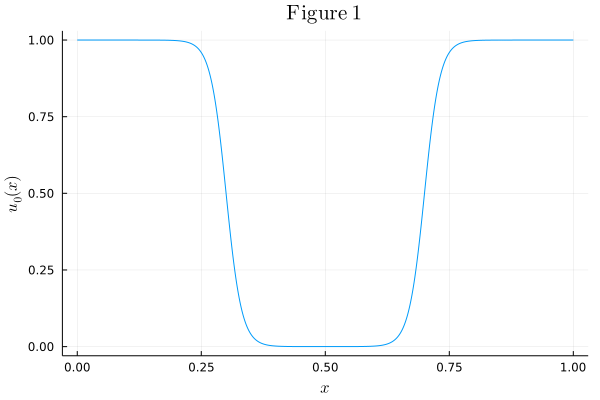

In [3]:
X = Chebyshev(0..1)
D = 0.05
Δ = Derivative(X)^2
B = [lneumann(X);rneumann(X)]
ϵ = 10^-1.5
u0 = Fun(x->(tanh((x-0.7)/ϵ)-tanh((x-0.3)/ϵ))/2+1,X)

fig1 = plot(u0,xlabel=L"x",ylabel=L"u_0(x)",title=L"\textrm{Figure\ 1}",legend=false,fmt=:png)
display(fig1)

## Data generation

Next, we will simulate some data by integrating the IC forward to $n$ time points $(t_j)_{j=1}^n\in[0,2]^n$. At each time point $t_j$, we sample $m$ spatial points $(x_i)_{i=1}^m\in[0,1]^m$. For both time and space, we will randomly sample the points. At each $t_j$, we have a data vector $\vec u_j := (u_{1j},\dots,u_{mj})$, where $u_{ij}:=u(x_i,t_j) + \sigma\,\eta(x_i,t_j)$ with Gaussian noise $\eta\sim\mathcal{N}(0,1)$ scaled by $\sigma$. Therefore, we can encode the entire data as a temporal sequence of spatially sampled vectors $(\vec u_j)_{j=1}^n$. (We could also just as easily have thought of the data as, e.g., an $m\times n$ matrix $U = (u_{ij})$... But we won't do that here as we also have a vector of `Fun`s that correspond nicely to each $\vec u_j$.)

To make things more concrete, we'll take $n=5$ time samples, $m=20$ space samples, and add $\sigma=0.02$ noise. 

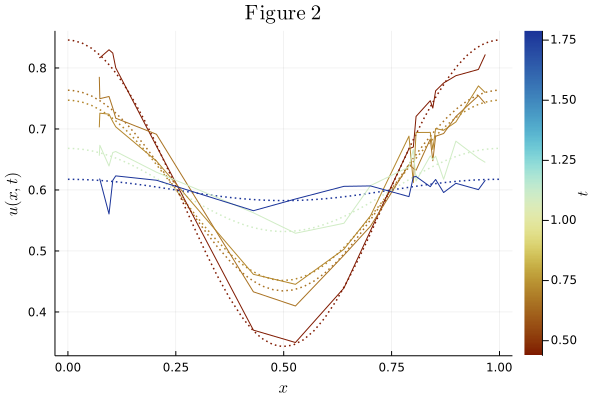

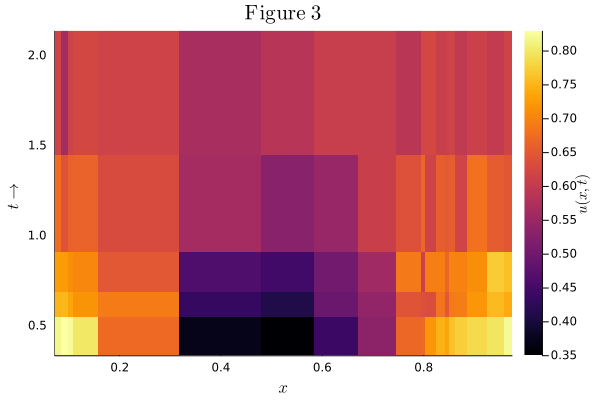

t = [0.4371733096376613, 0.6519534577271897, 0.7062232887984241, 1.0981022726311338, 1.7884908564019766]
x = [0.07271614209221577, 0.07399570839268677, 0.09521752297832098, 0.1039294604697858, 0.1108168569969088, 0.20516767351768161, 0.42977508345153304, 0.5271837562207654, 0.6395615996802734, 0.7011158355140754, 0.7902073277833203, 0.8003933116303876, 0.806704115694322, 0.8396219340580711, 0.8455146021206799, 0.8520189384186997, 0.8705393388965176, 0.898931120705672, 0.9511618942933061, 0.967142768915383]


In [4]:
Random.seed!(1234)
n = 5
t = sort(2*rand(n))
println("t = $t")
U = exp.(Ref(D*Δ),Ref(B),t,u0)    # sample in time

m = 20
x = sort(rand(m))
println("x = $x")
σ = 0.02
U⃗ = [max.(u.(x)+σ*randn(m),0) for u ∈ U]    # sample in space + add noise

fig2 = plot(xlabel=L"x",ylabel=L"u(x,t)",title=L"\textrm{Figure\ 2}")
fig2 = plot!(U,line_z=t',style=:dot,width=1.5,color=:roma,legend=false)
fig2 = plot!(x,U⃗,line_z=t',color=:roma,cbar=true,cbartitle=L"t",fmt=:png)
display(fig2)

fig3 = heatmap(x,t,vcat(U⃗...)',xlabel=L"x",ylabel=L"t\to",cbartitle=L"u(x,t)",title=L"\textrm{Figure\ 3}",fmt=:png)
display(fig3)

## System identification

Imagine that an experimentalist gathered the data $(\vec u_j)$ (visualized in Figs. 1 and 2) and handed it over to us. How should we go about "discovering" the equation of motion of the assay of cells, including the correct parameter(s)&mdash;in this case their motility $D$? This inverse problem is an example of **system identification**, meaning that we want to learn the structure of the PDE with the solution $\hat u$. Sometimes, we have a good idea of the mathematical model that leads to the data $(\vec u_{ij})$, which is called a white/grey box model. In other, more likely cases, we have very little knowledge of system, and we must use statistical methods to learn its properties.

No matter which case we have, we need to compare the solution from our predicted model, denoted $\hat u$, to the data $(\vec u_j)$. We can do this with **loss functional** $\mathcal{J}[\hat u;(\vec u_j)]$ that takes in the spatio-temporal solution from a candidate model and computes a scalar value of how *poorly* it fits the data. Ideally, once we have this, we just choose the candidate model whose functional value is lowest.

This is much easier said than done since there is an infinite number of models that we could consider. So let's restrict our analysis to the whitest box model, where we are absolutely confident that the cell distribution in the assay observes Eq. ([1](#mjx-eqn-eq:heat)). (See [Lagergren et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008462) for an example of a sophisticated grey box approach using neural networks.) Then, we can define the loss functional as the squared difference summed over all time samples:

$$
\mathcal{J}\left[\hat u_{\hat D};(\vec u_j)\right] := \sum_{j=1}^{n}\left\Vert \left(\hat u_{\hat D}(x_i,t_j)\right)_{i=1}^m-\vec u_j \right\Vert_2^2,
$$

where $\hat u_{\hat D}$ is the solution that solves Eq. ([1](#mjx-eqn-eq:heat)) with $D=\hat D$.

In [5]:
function 𝒥(D̂::Real,Δ::Operator,B::Operator,u0::Fun,U⃗::Vector,x::Vector,t::Vector)
    Û = exp.(Ref(D̂*Δ),Ref(B),t,u0)
    sum([norm(û.(x)-u⃗)^2 for (û,u⃗) ∈ zip(Û,U⃗)])
end

𝒥 (generic function with 1 method)

### Parameter estimation

Since the PDE ([1](#mjx-eqn-eq:heat)) is a 1-parameter system, we can think of the loss functional rather as a loss *function* $J(\hat D)$, and the system identification problem becomes a simple **parameter estimation** problem. To minimize $J(\hat D)$, we will evalute it at $p=50$ $\hat D$ values in the search space from 0.001 to 1, interpolate it as a `Fun`, then minimize the interpolation. The argument of minimimum is the optimal parameter estimate ${\hat D}^\ast$.

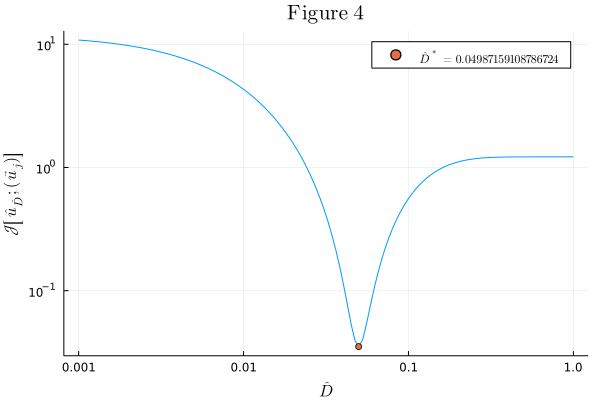

In [6]:
J(D̂::Real) = 𝒥(D̂,Δ,B,u0,U⃗,x,t)
log10D̂min,log10D̂max = -3,0
S = Chebyshev(log10D̂min..log10D̂max)
p = 50
D̂ = 10 .^points(S,p)
JD̂ = J.(D̂)
j = Fun(S,ApproxFun.transform(S,JD̂))
D̂opt = 10 .^argmin(j)

fig4 = plot(j,xticks=(log10D̂min:log10D̂max,10.0.^(log10D̂min:log10D̂max)),ylabel=L"\mathcal{J}\left[\hat u_{\hat D}\,;(\vec u_j)\right]",label=false)
fig4 = scatter!([log10(D̂opt)],[minimum(j)],yscale=:log10,xlabel=L"\hat D",label=L"{\hat D}^\ast=%$D̂opt",title=L"\textrm{Figure\ 4}",fmt=:png)
display(fig4)

That's pretty close (to the $D=0.05$ that was used to simulate the data)!

---

## Interfacing with nonlinear optimization and automatic differentiation

In the last section, our method to estimate ${\hat D}^\ast$ was very crude indeed. What if there were many more parameters in the model? What if function evaluations of $J$ were much more expensive? It would be nice to minimize the loss functional defined above, that includes ApproxFun types, with Julia-optimized nonlinear optimization packages like Optim.

In [7]:
using Optim

Optim.minimizer(optimize(J,1,NelderMead()))

LoadError: MethodError: no method matching optimize(::typeof(J), ::Int64, ::NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters})
[0mClosest candidates are:
[0m  optimize(::Any, ::Any, ::Any, [91m::AbstractArray[39m; inplace, autodiff, kwargs...) at C:\Users\matth\.julia\packages\Optim\DmCp2\src\multivariate\optimize\interface.jl:102
[0m  optimize(::Any, ::Any, ::Any, [91m::AbstractArray{T}[39m, [91m::Optim.AbstractOptimizer[39m) where T at C:\Users\matth\.julia\packages\Optim\DmCp2\src\multivariate\optimize\interface.jl:157
[0m  optimize(::Any, ::Any, ::Any, [91m::AbstractArray{T}[39m, [91m::Optim.Options[39m; inplace, autodiff) where T at C:\Users\matth\.julia\packages\Optim\DmCp2\src\multivariate\optimize\interface.jl:129
[0m  ...

Similarly, being able to use automatic differentiation packages like Zygote would allow gradient-required optimization algorithms like (L-)BFGS.

In [8]:
using Zygote

J'(D̂opt)

LoadError: MethodError: no method matching AbstractFloat(::Infinities.InfiniteCardinal{0})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at C:\Users\matth\AppData\Local\Programs\Julia-1.7.1\share\julia\base\rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at C:\Users\matth\AppData\Local\Programs\Julia-1.7.1\share\julia\base\boot.jl:770
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at C:\Users\matth\AppData\Local\Programs\Julia-1.7.1\share\julia\base\char.jl:50
[0m  ...